In [1]:
import os
import time
import pandas as pd
import numpy as np
from random import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from Bio import SeqIO
from multiprocessing import Process

import matplotlib.pyplot as plt
import math

In [2]:
dev = 'cuda'
dev2 = 'cuda'

# in tabs

In [3]:
first_round = pd.read_csv('cov_filtered_vf_637.csv',
                          index_col = 0)
# first_round

In [4]:
second_round = pd.read_csv('to_predict_vf.csv', 
                           index_col = 0)
# second_round

In [5]:
clade_info = pd.read_csv('clade_info_2.csv',
                         header = None,
                         index_col = 0)
# clade_info

In [6]:
d_to_df = {}

vfs = [*list(first_round.index), *second_round.index]
vfs = list(set(vfs))

for x in vfs:
    d_to_df[x] = [0.0] * 1127
    
df = pd.DataFrame(d_to_df)
# df

df.index = clade_info.index
# df

In [ ]:
for x in first_round.columns:# x is strain name
    if 'GCA' in x:
        continue
    else:
        for y in first_round.index:# y is vf name
            df.loc[x, y] = first_round.loc[y, x]

for x in clade_info.index:# x is strain name
    if 'GCA' not in x:
        continue
    else:
        for y in second_round.index:# y is vf name
            df.loc[x, y] = second_round.loc[y, x]

df

In [ ]:
df.to_csv('ready_to_learn.csv')

# train prep - dataset -dataloader

In [3]:
clade_info = pd.read_csv('clade_info_2.csv',
                         header = None,
                         index_col = 0)
# clade_info

In [4]:
df = pd.read_csv('ready_to_learn.csv',
                 index_col = 0)

df = df.div(10000)
df

,VFG049908(gb|WP_001080148),VFG045794(gb|WP_000992818),VFG049160(gb|WP_001327259),VFG041104(gb|NP_459278),VFG012591(gb|WP_001017167),VFG049899(gb|WP_001087735),VFG000891(gb|WP_000006208),VFG033484(gb|WP_000953248),VFG034772(gb|WP_000627910),VFG012615(gb|WP_000020049),...,VFG035902(gb|WP_000209220),VFG000800(gb|WP_000381516),VFG000619(gb|NP_709458),VFG044324(gb|WP_032447693),VFG000750(gb|WP_001261182),VFG000918(gb|WP_001312167),VFG048606(gb|WP_004213922),VFG043734(gb|CAD48851),VFG050167(gb|WP_000038461),VFG041103(gb|NP_459277)
0,,,,,,,,,,,,,,,,,,,,,
GCA_024008355.1_PDT001338878.3_genomic,0.009905,0.01000,0.0,0.0,0.009796,0.000000,0.000000,0.00000,0.000000,0.009434,...,0.0,0.000000,0.000000,0.000000,0.000000,0.009902,0.0,0.0,0.0,0.0
GCA_020550965.1_PDT001158330.1_genomic,0.000000,0.00991,0.0,0.0,0.009777,0.000000,0.000000,0.00000,0.000000,0.009717,...,0.0,0.000000,0.000000,0.009922,0.000000,0.009814,0.0,0.0,0.0,0.0
GCA_000194685.2_ASM19468v2_genomic,0.000000,0.01000,0.0,0.0,0.009806,0.000000,0.000000,0.00991,0.000000,0.009454,...,0.0,0.000000,0.000000,0.000000,0.000000,0.009803,0.0,0.0,0.0,0.0
E2348_69,0.000000,0.00994,0.0,0.0,0.009806,0.000000,0.000000,0.01000,0.000000,0.009454,...,0.0,0.008463,0.000000,0.000000,0.010000,0.009945,0.0,0.0,0.0,0.0
GCA_015137895.1_PDT000854705.1_genomic,0.000000,0.00994,0.0,0.0,0.009796,0.000000,0.000000,0.00982,0.000000,0.009576,...,0.0,0.009948,0.000000,0.000000,0.009925,0.009967,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_009683975.1_ASM968397v1_genomic,0.000000,0.00997,0.0,0.0,0.009650,0.000000,0.009957,0.00000,0.009707,0.009758,...,0.0,0.000000,0.009964,0.009953,0.000000,0.009694,0.0,0.0,0.0,0.0
GCA_009684135.1_ASM968413v1_genomic,0.000000,0.00000,0.0,0.0,0.009650,0.000000,0.000000,0.00000,0.009707,0.009758,...,0.0,0.000000,0.009964,0.009953,0.000000,0.009694,0.0,0.0,0.0,0.0
GCA_017002615.1_PDT000966258.1_genomic,0.009905,0.01000,0.0,0.0,0.009670,0.009616,0.000000,0.00000,0.009739,0.009697,...,0.0,0.000000,0.000000,0.009945,0.000000,0.009683,0.0,0.0,0.0,0.0


In [5]:
combined = pd.concat([clade_info, df], 
                     axis = 1)
# combined

In [6]:
softmax_d = {}

for x in list(set(clade_info.loc[:, 1])):
    softmax_d[x] = []
    
for x in clade_info.index:
    softmax_d[clade_info.loc[x, 1]].append(x)

In [7]:
softmax_answer = {
    'A': [1,0,0,0,0,0],
    'B1': [0,1,0,0,0,0],
    'B2': [0,0,1,0,0,0],
    'D': [0,0,0,1,0,0],
    'E': [0,0,0,0,1,0],
    'N9': [0,0,0,0,0,1],
}

softmax_answer = {
    'A': [1],
    'B1': [2],
    'B2': [3],
    'D': [4],
    'E': [5],
    'N9': [6],
}

In [8]:
train_set = []
test_set = []

for x in softmax_d.keys():
#     total = sample(softmax_d[x], 180)
    total = softmax_d[x]
    
    train_set.extend(total[0: 120])
    test_set.extend(total[120: ])
    
print(len(train_set))
print(len(test_set))

720
407


to_stack_x = []
to_stack_y = []


for x in train_set:
    to_stack_x.append(torch.from_numpy(np.array(df.loc[x, :])
                                      ).type(torch.FloatTensor).to(device = dev)
                     )
                                               
    to_stack_y.append([[softmax_answer[clade_info.loc[x, 1]
                                     ]
                       ]
                      ]
                     )

to_stack_x_test = []
to_stack_y_test = []


for x in test_set:
    to_stack_x_test.append(torch.from_numpy(np.array(df.loc[x, :])
                                           ).type(torch.FloatTensor).to(device = dev)
                          )
                                               
    to_stack_y_test.append([[softmax_answer[clade_info.loc[x, 1]
                                          ]
                            ]
                           ]
                          )

```Python
train_x = torch.stack((to_stack_x))
test_x = torch.stack((to_stack_x_test))

# train_x = train_x.reshape(2*each_1, 1, 4, 555)
# test_x = test_x.reshape(2*each_2, 1, 4, 555)

train_x = train_x.reshape(len(train_set), 1, 1, 555)
test_x = test_x.reshape(len(test_set), 1, 1, 555)
```

```Python
train_y = torch.FloatTensor(to_stack_y).to(device = dev)
test_y = torch.FloatTensor(to_stack_y_test).to(device = dev)

# train_y = train_y.type(torch.LongTensor).to(device = dev)
# test_y = test_y.type(torch.LongTensor).to(device = dev)
```

a = ['a', 'b', 'c']
a = [a.index(x) for x in ['a', 'c']]
a

In [21]:
class VF_Dataset(Dataset):
    def __init__(self, 
                 set_to_read, 
                 in_tab = combined,
                 des = dev,
                 lab_convert = softmax_answer
#                  dir_ours = , dir_GCA
                ):
        
        
        self.in_tab = in_tab
        
        self.indx = list(self.in_tab.index)
        
        self.to_read_indx = [self.indx.index(x) for x in set_to_read]
        
        self.go_tab = self.in_tab.iloc[self.to_read_indx, :]
        
        self.des = des
        
        self.lab_convert_d = softmax_answer
        
    def __len__(self):
        return len(self.go_tab.index)

    def __getitem__(self, idx):
        ft = torch.from_numpy(np.array(self.go_tab.iloc[idx, 1: ],
                                       dtype = 'float32')
                             ).type(torch.FloatTensor).to(device = self.des)
        ft = ft.reshape(555)
        
        lab = torch.FloatTensor([self.lab_convert_d[self.go_tab.iloc[idx, 0]
                                                   ]
                                ]
                               ).to(device = self.des)
        lab = lab.reshape(6)
        
        return ft, lab

In [22]:
training_data = VF_Dataset(set_to_read = train_set)
testing_data = VF_Dataset(set_to_read = test_set)

In [23]:
train_dataloader = DataLoader(training_data, batch_size = 8, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size = 8, shuffle=True)

 training_data[0]

len(training_data)

for data in train_dataloader:
    print(data)
    i, l = data
    print(i.shape)
    print(l.shape)

# model 

In [66]:
#```Python
class the_model(nn.Module):

    def __init__(self):
        super(the_model, self).__init__()
        
        self.fc1 = nn.Linear(555, 6).to(torch.device(dev))
        
        
        
    def forward(self, x):
        x = self.fc1(x)

        
        return x
#```

In [67]:
for x in range(19):
#     print('self.dropout' + str(x) + ' = nn.Dropout(p=0.1)')
#     print('x = self.dropout' + str(x) + '(x)')
    print('x = self.fc' + str(x + 1) + '(x)')

x = self.fc1(x)
x = self.fc2(x)
x = self.fc3(x)
x = self.fc4(x)
x = self.fc5(x)
x = self.fc6(x)
x = self.fc7(x)
x = self.fc8(x)
x = self.fc9(x)
x = self.fc10(x)
x = self.fc11(x)
x = self.fc12(x)
x = self.fc13(x)
x = self.fc14(x)
x = self.fc15(x)
x = self.fc16(x)
x = self.fc17(x)
x = self.fc18(x)
x = self.fc19(x)


 ```Python
class the_model(nn.Module):

    def __init__(self):
        super(the_model, self).__init__()
        
#         self.dropout0 = nn.Dropout(p=0.1)
#         self.dropout1 = nn.Dropout(p=0.1)
#         self.dropout2 = nn.Dropout(p=0.1)
#         self.dropout3 = nn.Dropout(p=0.1)
#         self.dropout4 = nn.Dropout(p=0.1)
#         self.dropout5 = nn.Dropout(p=0.1)
#         self.dropout6 = nn.Dropout(p=0.1)
#         self.dropout7 = nn.Dropout(p=0.1)
#         self.dropout8 = nn.Dropout(p=0.1)
#         self.dropout9 = nn.Dropout(p=0.1)
#         self.dropout10 = nn.Dropout(p=0.1)
#         self.dropout11 = nn.Dropout(p=0.1)
#         self.dropout12 = nn.Dropout(p=0.1)
#         self.dropout13 = nn.Dropout(p=0.1)
#         self.dropout14 = nn.Dropout(p=0.1)
#         self.dropout15 = nn.Dropout(p=0.1)
#         self.dropout16 = nn.Dropout(p=0.1)
#         self.dropout17 = nn.Dropout(p=0.1)
#         self.dropout18 = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(555, 555).to(torch.device(dev))
        
        self.fc2 = nn.Linear(555, 555).to(torch.device(dev))
        
        self.fc3 = nn.Linear(555, 555).to(torch.device(dev))
        
        self.fc4 = nn.Linear(555, 555).to(torch.device(dev))
        
        self.fc5 = nn.Linear(555, 555).to(torch.device(dev))
        
        self.fc6 = nn.Linear(555, 555).to(torch.device(dev))
        
        self.fc7 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc8 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc9 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc10 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc11 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc12 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc13 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc14 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc15 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc16 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc17 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc18 = nn.Linear(555, 555).to(torch.device(dev))
        self.fc19 = nn.Linear(555, 6).to(torch.device(dev))
        
#         self.mo1 = nn.Sigmoid().to(torch.device(dev))
        
#         self.mo2 = nn.Softmax(dim = 1).to(torch.device(dev))
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        x = self.fc9(x)
        x = self.fc10(x)
        x = self.fc11(x)
        x = self.fc12(x)
        x = self.fc13(x)
        x = self.fc14(x)
        x = self.fc15(x)
        x = self.fc16(x)
        x = self.fc17(x)
        x = self.fc18(x)
        x = self.fc19(x)
        
#         x = self.mo1(x)
#         x = self.mo2(x)
        
        return x
 ```

In [78]:
net = the_model()

In [79]:
loss_function = nn.CrossEntropyLoss().to(torch.device(dev))
# loss_function = nn.NLLLoss().to(torch.device(dev))
optimizer = torch.optim.Adam(net.parameters(), 
                             lr = 1e-1,
                             weight_decay = 1e-5
                            )

os.getcwd()

net(testing_data[0][0])

testing_data[0][1]

loss_function(net(testing_data[0][0]),
              testing_data[0][1]
             )

torch.ones(5, 6)

torch.zeros(5, 6)

loss_function(torch.ones(5, 4), 
              torch.ones(5, 4))

0
1.0736076914601855
1.7918177071739645


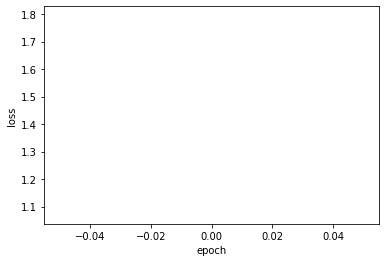

1
0.6188263876570596
0.6632585198271508


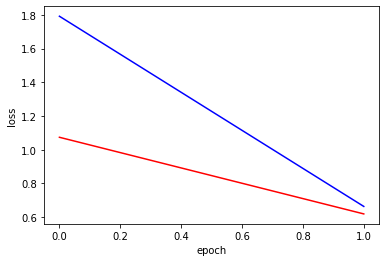

2
0.49327195518546635
0.49881286188667895


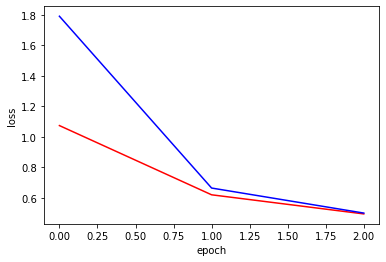

3
0.4235977969235844
0.4049353374570024


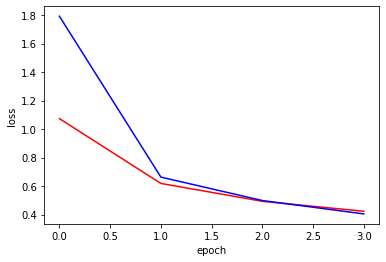

4
0.3880456717477904
0.36944377247024984


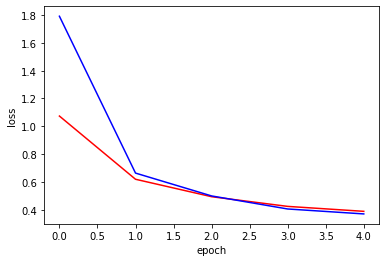

5
0.36460646275016995
0.33331918073635475


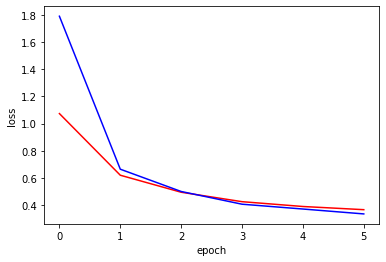

6
0.3472880002525118
0.3255641683936119


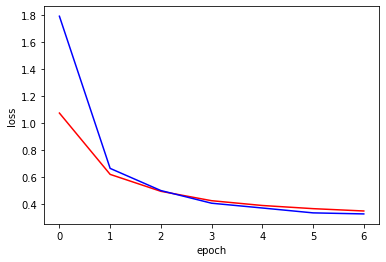

7
0.3475851446390152
0.32832907315562754


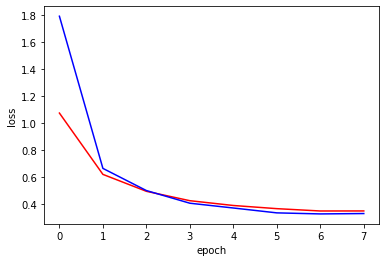

8
0.33361922080318135
0.2890086394606852


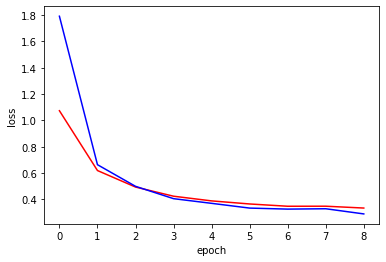

9
0.327690996726354
0.28184723240487713


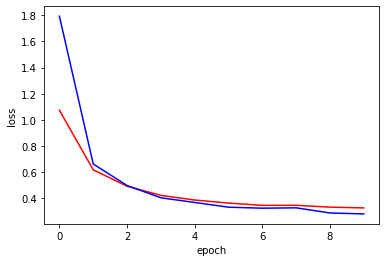

10
0.3252352600296338
0.3077668182405771


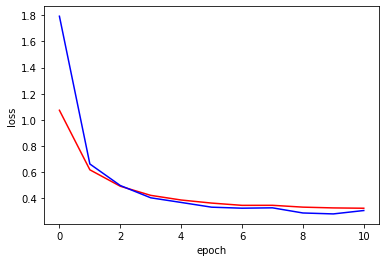

11
0.317638209876087
0.28429232084868


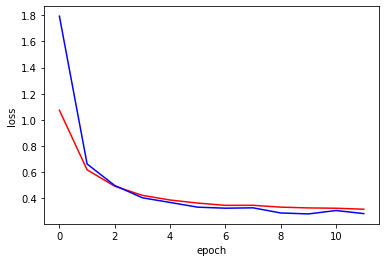

12
0.31948913402027557
0.28531090111709106


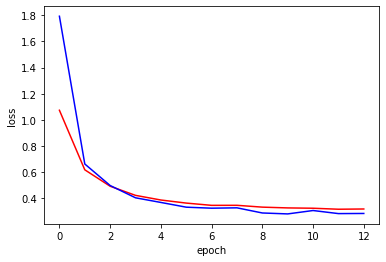

13
0.3172773011856609
0.29789459442391114


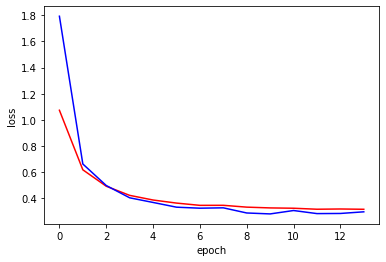

14
0.3177590795689159
0.28670021058881984


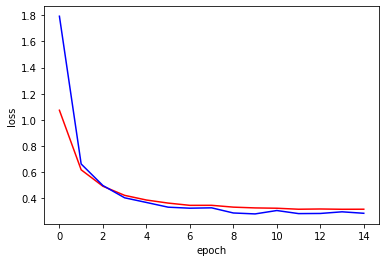

15
0.31773114436202576
0.28780940408800165


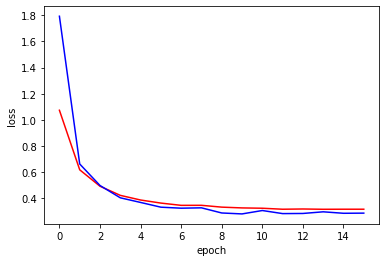

16
0.3170210037794378
0.2813573263439478


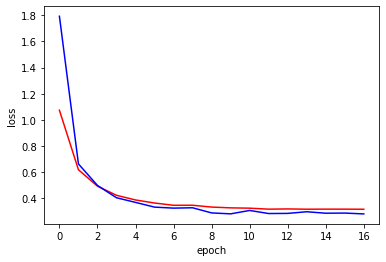

17
0.31508541156848274
0.3029111480596019


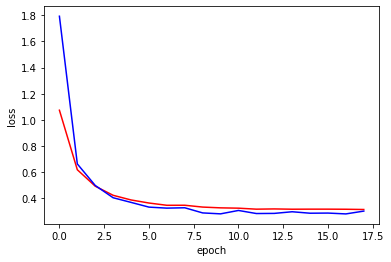

18
0.3138666096660826
0.27086025534891617


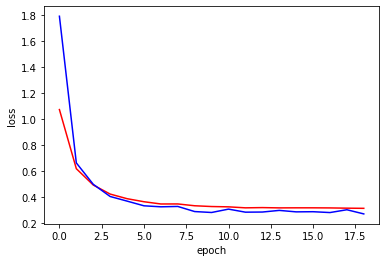

19
0.32458929038710066
0.27834000774458345


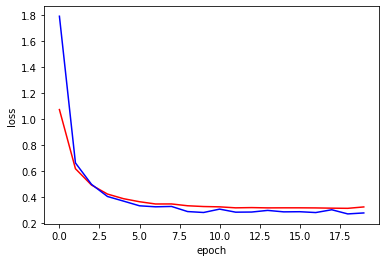

20
0.3117821042736371
0.28539897180071067


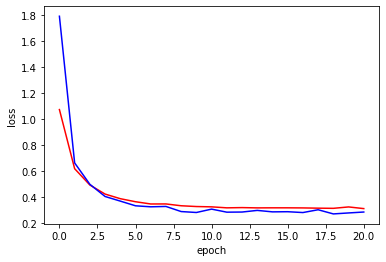

21
0.31501126570834054
0.2640067905771966


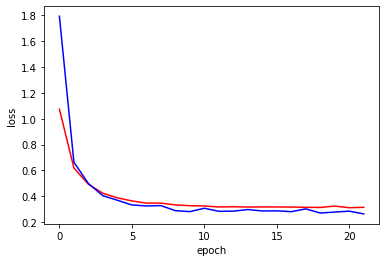

22
0.31247288137674334
0.2760515042087611


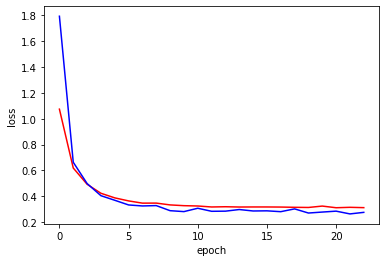

23
0.314152686463462
0.26933592280336455


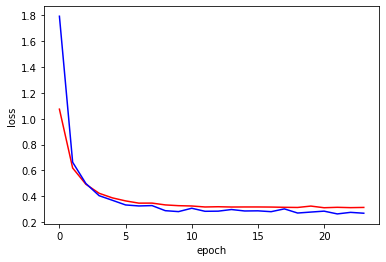

24
0.31308874620331656
0.27561137708378775


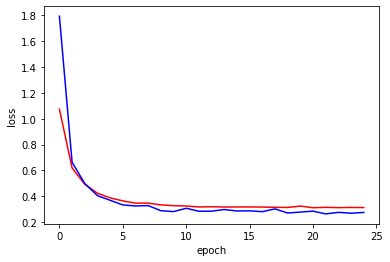

25
0.31722467525137793
0.28085017920124766


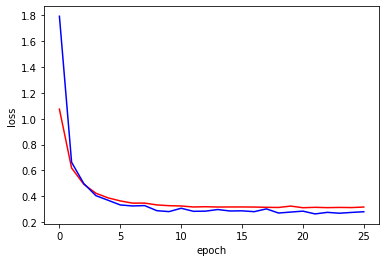

26
0.31448864233162666
0.28053419847114414


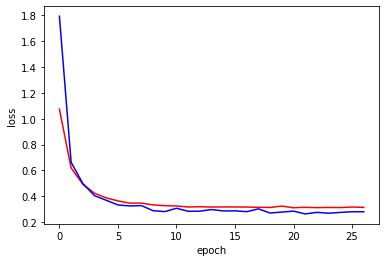

27
0.31512872551878296
0.2829769227434607


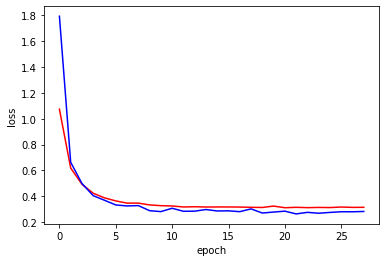

28
0.3177411608397961
0.2867457910495646


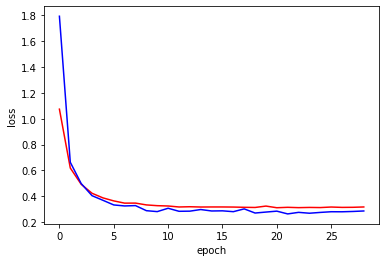

29
0.3138368742333518
0.2836705471078555


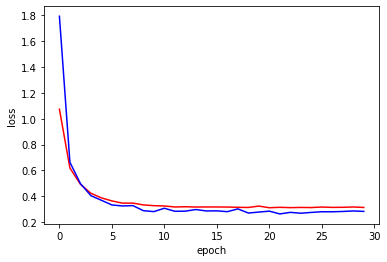

30
0.31349459869994056
0.2923092582062179


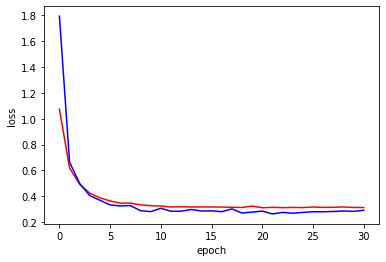

31
0.3102766757210096
0.2991320460158236


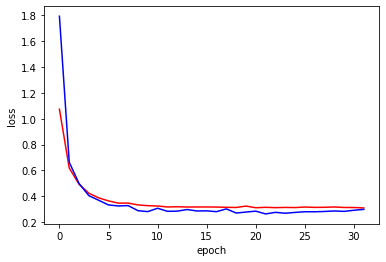

32
0.31715617411666447
0.2853925841696122


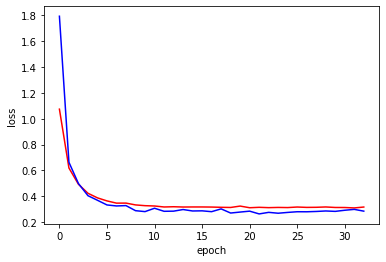

33
0.3193378950158755
0.27832279602686566


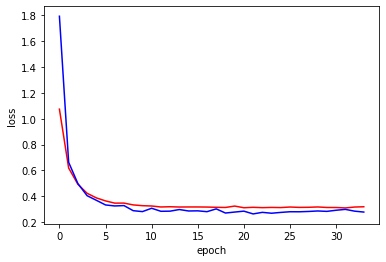

34
0.3128046782480346
0.29176685491613313


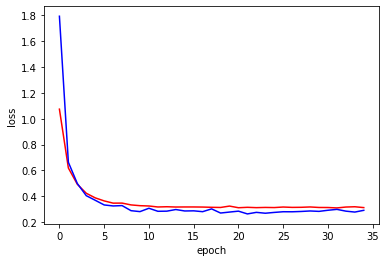

35
0.31427263071139655
0.2753746198380695


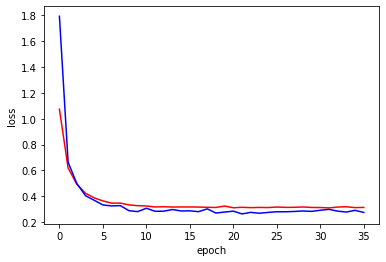

36
0.3161874991324213
0.27258926279404583


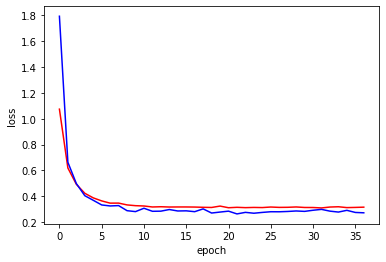

37
0.3146087400615215
0.2843732414584534


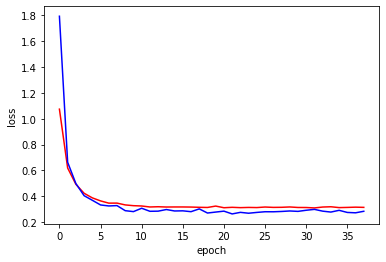

38
0.3148332968354225
0.2737816341367422


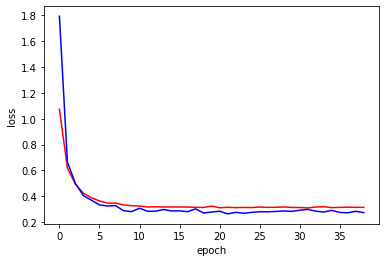

39
0.3150544469555219
0.28592463538927193


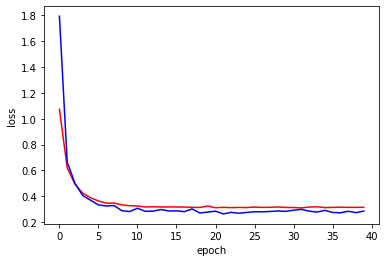

40
0.31055497543679345
0.28479034044578966


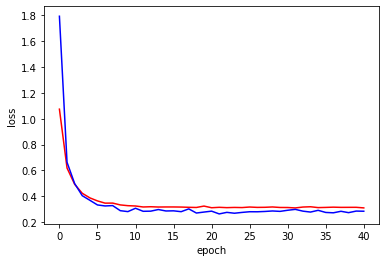

41
0.31883933825625316
0.33276186781186684


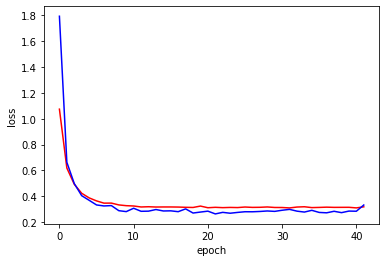

42
0.3142998246683015
0.2654229371863253


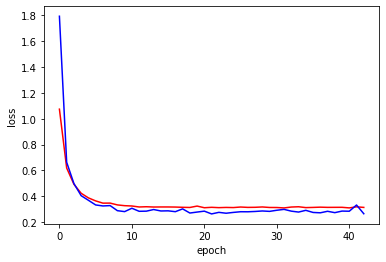

43
0.3206106577482488
0.29793009687872496


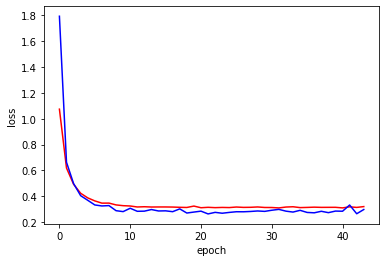

44


KeyboardInterrupt: 

In [80]:
losses = []
losses_test = []

for epoch in range(300):
    
    print(epoch)
    
    with torch.no_grad():
        
        record_of_test_loss = 0.0
        count = 0
        for data_test in test_dataloader:
            i_test, l_test = data_test

            pred_y_test = net(i_test)

            loss_test = loss_function(pred_y_test, l_test)
            
            record_of_test_loss = record_of_test_loss + loss_test.item()
            
            count += 1

        losses_test.append(record_of_test_loss/count)
    
    record_of_train_loss = 0.0
    count = 0
    for data in train_dataloader:
        i, l = data
        
        pred_y = net(i)
        
        loss = loss_function(pred_y, l)
        
        record_of_train_loss = record_of_train_loss + loss.item()
        
        count += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
                    
    losses.append(record_of_train_loss/count)
        
    print(losses[-1])
    print(losses_test[-1])
    
    plt.plot(losses, 'r')
    plt.plot(losses_test, 'b')
    plt.ylabel('loss')
    plt.xlabel('epoch')
#     plt.title('Train')
    plt.show()

    torch.save(net.state_dict(), 'models/vf_pre_' + str(epoch) + '_epoch_.pth')

In [81]:
min(losses_test)

0.2640067905771966

In [82]:
min(losses)

0.3102766757210096

In [83]:
losses_test.index(min(losses_test))

21

In [84]:
losses.index((min(losses)))

31

# save load test

In [85]:
model_load_1 = the_model()
model_load_2 = the_model()

In [86]:
# model_load_1.load_state_dict(torch.load('models/vf_pre109_epoch_.pth'))
model_load_2.load_state_dict(torch.load('models/vf_pre_21_epoch_.pth'))

<All keys matched successfully>

testing_data[0][0]

model_load_1(testing_data[0][0])

model_load_2(testing_data[0][0])

loss_function(model_load_1(testing_data[0][0]),
              testing_data[0][1]
             )

loss_function(model_load_2(testing_data[0][0]),
              testing_data[0][1]
             )

testing_data[0][1].argmax()

model_load_2(testing_data[0][0]).argmax()

m1 = nn.Sigmoid().to(torch.device(dev))
m2 = nn.Softmax(dim = 1).to(torch.device(dev))

for data in test_dataloader:
    
    i, l = data
    print('input')
    print(i)
    a = model_load_2(i)
    print('output')
    print(a)
    print('Sigmoid')
    print(m1(a))
    print('Softmax')
    print(m2(a))
    print('answer')
    print(l)
    print('loss')
    print(loss_function(a, l))
    break


In [87]:
count = 0
rec = 0
for data in test_dataloader:
#     print(count)
    
    i, l = data
    
#     print((model_load_2(i).argmax(1) == l.argmax(1)
#           ).sum()
#          )
    
    med = (model_load_2(i).argmax(1) == l.argmax(1)
          ).sum()
    rec = rec + med.item()
#     print(model_load_2(i).argmax(1))
#     print(l.argmax(1))
    count += 1
    
print(rec)

401


In [88]:
count = 0
rec = 0
for data in train_dataloader:
#     print(count)
    
    i, l = data
    
#     print((model_load_2(i).argmax(1) == l.argmax(1)
#           ).sum()
#          )
    
    med = (model_load_2(i).argmax(1) == l.argmax(1)
          ).sum()
    rec = rec + med.item()
#     print(model_load_2(i).argmax(1))
#     print(l.argmax(1))
    count += 1
    
print(rec)

705


# how things work

In [36]:
input = torch.randn(2, 3)
input

tensor([[-0.0676, -1.1752, -1.0730],
        [ 1.1128, -0.3278, -0.3886]])

In [37]:
m = nn.Softmax(dim=1)
# output = m(input)
m(input)

tensor([[0.5895, 0.1947, 0.2157],
        [0.6851, 0.1622, 0.1527]])

In [38]:
s = 0
for x in input[0]:
    s = s + pow(math.e, x)

In [39]:
s

tensor(1.5854)

In [40]:
pow(math.e, input[0][0])/s

tensor(0.5895)

In [ ]:
input = torch.randn(2, 2)
input

In [ ]:
m = nn.Sigmoid()
m(input)

In [ ]:
1/(1 + pow(math.e, -input[0][0]))

In [ ]:
m = nn.Dropout(p=0.5)

In [ ]:
input = torch.randn(4, 4)
input

In [ ]:
m(input)

# get parameters

In [ ]:
for p in model_load_2.parameters():
    if p.requires_grad:
        for q in p.data:
            print(len(q))
            for x in q:
                print(x)
            break
            
    print('-----')
    break

for data in train_dataloader:
    i, l = data
    
    print((model_load_2(i).argmax(1) == l.argmax(1)
          ).sum()
         )
    
#     print(model_load_2(i).argmax(1))
#     print(l.argmax(1))